# Cis Effects Template

## Setup

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cptac
from scipy import stats
from cnvutils import *
import statsmodels.stats.multitest
import cptac.utils

## Stuff to fill out

In [2]:
cancer_types = {
    # Put here all the types of cancer that you want to look at. 
    'luad': cptac.Luad(),
    'hnscc': cptac.Hnscc(),
    'ovarian': cptac.Ovarian(),
#     'colon': cptac.Colon(),
    'brca': cptac.Brca(),
    'lscc': cptac.Lscc()
}

KeyboardInterrupt: 

In [13]:
# Enter the Chromosome and arm you are looking at. 
CHROMOSOME = '5'
ARM = 'q'

## Load all the data

In [ ]:
proteomics = dict()
cnv = dict()
transcriptomics = dict()
for cancer_type in cancer_types:
    proteomics[cancer_type] = cancer_types[cancer_type].get_proteomics()
    cnv[cancer_type] = cancer_types[cancer_type].get_CNV()
    transcriptomics[cancer_type] = cancer_types[cancer_type].get_transcriptomics()

In [14]:
locations = get_gene_locations()

In [15]:
# Get just the genes that are in our event
subset_event = locations[(locations.chromosome == CHROMOSOME) & (locations.arm == ARM)]
genes = set(subset_event.index.get_level_values('Name'))

In [19]:
len([gene for gene in genes if '.' not in gene])

1310

## Run Pearson Tests

In [7]:
def run_pearsons(protein, cnv_df, omics):
    try:
        if protein in cnv_df.columns.get_level_values('Name'):
            cnv_data = cnv_df.loc[:,cnv_df.columns.get_level_values('Name')==protein]
            cnv_column_name = cnv_data.columns.tolist()[0]
        else:
            return (np.nan, np.nan)
        omics_data = omics[protein]
        if isinstance(omics_data, pd.DataFrame):
            omics_data = omics.iloc[:,0]
        omics_data.name = 'omics'
        df = pd.concat([cnv_data, omics_data], axis=1)
        df.dropna(inplace=True)
        if len(df) < 3:
            return (np.nan,np.nan)
        return stats.pearsonr(df[cnv_column_name], df['omics'])
    except Exception as e:
        print(e)

### Proteomics

In [8]:
proteomics_results = None
for cancer_type in proteomics.keys():
    try:
        # We will use the index from the proteomics table. 
        proteomics_table = proteomics[cancer_type].copy()
        proteomics_table = proteomics_table.loc[:, proteomics_table.columns.get_level_values('Name').isin(genes)]
        if isinstance(proteomics_table.columns, pd.MultiIndex):
            proteomics_table = proteomics_table.droplevel('Database_ID', axis=1)
        pvalues = list()
        rvalues = list()
        index = proteomics_table.columns.get_level_values('Name').tolist()
        for protein in index:
            r, p = run_pearsons(protein, cnv[cancer_type], proteomics_table)
            pvalues.append(p)
            rvalues.append(r)
        # Correct for multiple tests
        pvalues = np.array(pvalues)
        mask = np.isfinite(pvalues)
        pval_corrected = np.empty(len(pvalues))
        pval_corrected.fill(np.nan)
        pval_corrected[mask] = statsmodels.stats.multitest.multipletests(pvals=list(pvalues[mask]), alpha=0.05, method='fdr_bh')[1]
        temp = pd.DataFrame(data={f'{cancer_type}_pvalue_proteomics': pval_corrected, f'{cancer_type}_rvalue_proteomics': rvalues}, index=index)
        temp.index.name = 'Name'
        if proteomics_results is not None:
            proteomics_results = proteomics_results.join(temp, how='outer')
        else:
            proteomics_results = temp
    except Exception as e:
        print(e)

In [9]:
proteomics_results

,luad_pvalue_proteomics,luad_rvalue_proteomics,hnscc_pvalue_proteomics,hnscc_rvalue_proteomics,ovarian_pvalue_proteomics,ovarian_rvalue_proteomics,brca_pvalue_proteomics,brca_rvalue_proteomics,lscc_pvalue_proteomics,lscc_rvalue_proteomics
Name,,,,,,,,,,
ADAMTS16,2.711052e-01,0.175413,8.739485e-01,0.072461,1.979104e-01,-0.172921,5.429126e-01,0.101156,9.827390e-01,-0.002878
AMACR,6.163068e-06,0.435649,7.748178e-08,0.510344,1.481638e-01,0.257538,4.613001e-01,0.095369,4.519460e-07,0.479800
ANKH,NaN,NaN,NaN,NaN,1.945700e-01,0.224015,NaN,NaN,NaN,NaN
BASP1,7.565965e-01,-0.046351,8.553766e-01,0.029539,1.000737e-01,-0.214083,2.962017e-01,0.130609,1.141637e-01,0.172809
BRD9,3.173628e-08,0.519008,1.365563e-02,0.258957,8.047907e-03,0.327579,8.996035e-01,0.011541,2.496750e-05,0.409576
...,...,...,...,...,...,...,...,...,...,...
UGT3A2,NaN,NaN,3.965964e-03,0.822914,NaN,NaN,NaN,NaN,NaN,NaN
WDR70,1.780379e-23,0.793912,1.683065e-16,0.713902,8.250460e-08,0.592114,6.667029e-07,0.481377,3.834326e-19,0.747708
ZFR,1.091014e-12,0.632347,1.633476e-11,0.611053,2.594076e-02,0.276625,5.651299e-03,0.285511,6.254077e-09,0.542053


### Transcriptomics

In [10]:
transcriptomics_results = None
for cancer_type in transcriptomics.keys():
    try:
        # We will use the index from the proteomics table. 
        transcriptomics_table = transcriptomics[cancer_type].copy()
        transcriptomics_table = transcriptomics_table.loc[:, transcriptomics_table.columns.get_level_values('Name').isin(genes)]
        if isinstance(transcriptomics_table.columns, pd.MultiIndex):
            transcriptomics_table = transcriptomics_table.droplevel('Database_ID', axis=1)
        pvalues = list()
        rvalues = list()
        index = transcriptomics_table.columns.get_level_values('Name').tolist()
        for protein in index:
            r, p = run_pearsons(protein, cnv[cancer_type], transcriptomics_table)
            pvalues.append(p)
            rvalues.append(r)
        pvalues = np.array(pvalues)
        mask = np.isfinite(pvalues)
        pval_corrected = np.empty(len(pvalues))
        pval_corrected.fill(np.nan)
        pval_corrected[mask] = statsmodels.stats.multitest.multipletests(pvals=list(pvalues[mask]), alpha=0.05, method='fdr_bh')[1]
        temp = pd.DataFrame(data={f'{cancer_type}_pvalue_transcriptomics': pval_corrected, f'{cancer_type}_rvalue_transcriptomics': rvalues}, index=index)
        temp.index.name = 'Name'
        if transcriptomics_results is not None:
            transcriptomics_results = transcriptomics_results.join(temp, how='outer')
        else:
            transcriptomics_results = temp
    except Exception as e:
        print(e)

C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\

In [11]:
transcriptomics_results

,luad_pvalue_transcriptomics,luad_rvalue_transcriptomics,hnscc_pvalue_transcriptomics,hnscc_rvalue_transcriptomics,ovarian_pvalue_transcriptomics,ovarian_rvalue_transcriptomics,brca_pvalue_transcriptomics,brca_rvalue_transcriptomics,lscc_pvalue_transcriptomics,lscc_rvalue_transcriptomics
Name,,,,,,,,,,
ADAMTS16,2.681387e-01,0.122799,7.717370e-01,-0.044945,8.838099e-01,0.020170,6.586359e-01,-0.064373,2.982648e-01,0.117073
ADCY2,2.099343e-01,0.138661,9.977236e-01,0.000733,2.284526e-02,0.249549,1.195029e-01,-0.171609,4.359291e-02,0.211374
AGXT2,1.251039e-01,0.220193,6.322741e-01,-0.068402,1.129148e-01,-0.181768,6.875566e-01,-0.081248,5.450437e-01,-0.131581
AHRR,2.731897e-04,0.355924,2.239854e-02,0.247116,NaN,NaN,4.070899e-10,0.570648,NaN,NaN
AMACR,1.138752e-06,0.459728,3.446244e-08,0.519953,NaN,NaN,9.609302e-01,-0.005907,8.478533e-09,0.530740
...,...,...,...,...,...,...,...,...,...,...
ZDHHC11,1.350230e-06,0.456192,4.492418e-07,0.483203,8.925717e-01,0.017001,2.946954e-01,0.125911,3.243542e-02,0.222877
ZDHHC11B,3.437522e-03,0.292020,1.913753e-07,0.495973,NaN,NaN,NaN,NaN,NaN,NaN
ZFR,1.138155e-17,0.714144,5.226408e-23,0.790261,5.093476e-05,0.416470,4.498449e-04,0.345433,1.337193e-18,0.731705


## Create Graphs

In [12]:
# Join the graphs
all_results = transcriptomics_results.join(proteomics_results)

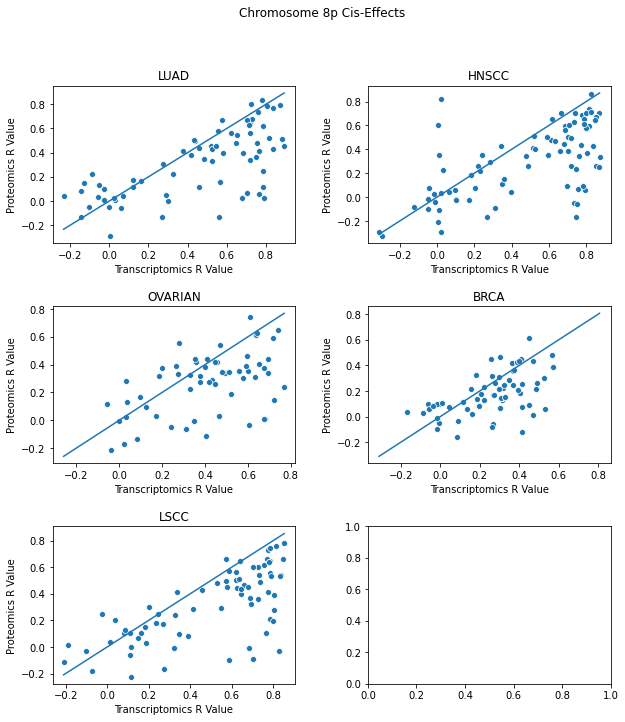

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=False, figsize=(10,11))
fig.suptitle("Chromosome 8p Cis-Effects")
count = 0
for cancer_type in proteomics.keys():
    sns.scatterplot(x=f'{cancer_type}_rvalue_transcriptomics', y=f'{cancer_type}_rvalue_proteomics', data=all_results, ax=axs[count//2][count%2])
    axs[count//2][count%2].set_title(cancer_type.upper())
    axs[count//2][count%2].set_xlabel("Transcriptomics R Value")
    axs[count//2][count%2].set_ylabel("Proteomics R Value")
    min_val = np.min(all_results[f'{cancer_type}_rvalue_transcriptomics'])
    max_val = np.max(all_results[f'{cancer_type}_rvalue_transcriptomics'])
    axs[count//2][count%2].plot([min_val,max_val], [min_val,max_val])
    count += 1
plt.subplots_adjust(hspace=0.4, wspace=0.3)